# 4. Model Interpretability for Machine Learning in Metabolomics

Model interpretability is crucial in scientific research, especially in metabolomics where understanding *why* a model makes certain predictions can lead to biological insights. This notebook explores techniques to understand and interpret machine learning models.

## Learning Objectives
- Understand the difference between white box and black box models
- Learn to extract and visualize feature importance
- Master SHAP (Shapley Additive Explanations) for model explanation
- Create interpretable visualizations for scientific communication
- Apply interpretability techniques to metabolomics data
- Understand limitations and best practices for model interpretation

## Import Required Libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

# Initialize SHAP
shap.initjs()

## 1. Understanding Model Interpretability

**White Box Models** (Intrinsically Interpretable):
- Linear/Logistic Regression: Coefficients directly indicate feature importance
- Decision Trees: Rules are transparent and human-readable
- Naive Bayes: Probabilistic relationships are clear

**Black Box Models** (Require Interpretation Techniques):
- Random Forest: Ensemble of trees with complex interactions
- SVM: Complex decision boundaries in high-dimensional space
- Neural Networks: Multiple layers of non-linear transformations

Let's create a dataset and demonstrate both types of models.

In [26]:
# Generate synthetic metabolomics data with interpretable features
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=3,
    n_clusters_per_class=1,
    weights=[0.6, 0.4],
    random_state=42
)

# Create meaningful feature names for metabolomics context
metabolite_categories = {
    'Amino_Acids': ['Alanine', 'Glycine', 'Leucine', 'Valine'],
    'Organic_Acids': ['Lactate', 'Pyruvate', 'Succinate', 'Fumarate'],
    'Lipids': ['Palmitate', 'Oleate', 'Stearate', 'Linoleate'],
    'Sugars': ['Glucose', 'Fructose', 'Galactose', 'Ribose'],
    'Others': ['Creatinine', 'Urea', 'Choline', 'Betaine']
}

feature_names = []
for category, metabolites in metabolite_categories.items():
    feature_names.extend(metabolites)

# Create DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['Disease_Status'] = y  # 0 = Healthy, 1 = Disease

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create scaled DataFrames for easier interpretation
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names[:5]}...")
print(f"Class distribution: {np.bincount(y)}")
print(f"Target classes: 0=Healthy, 1=Disease")

Dataset shape: (1000, 20)
Features: ['Alanine', 'Glycine', 'Leucine', 'Valine', 'Lactate']...
Class distribution: [596 404]
Target classes: 0=Healthy, 1=Disease


## 2. White Box Models: Intrinsic Interpretability

Let's start with models that are inherently interpretable.

### 2.1 Logistic Regression: Coefficient Analysis

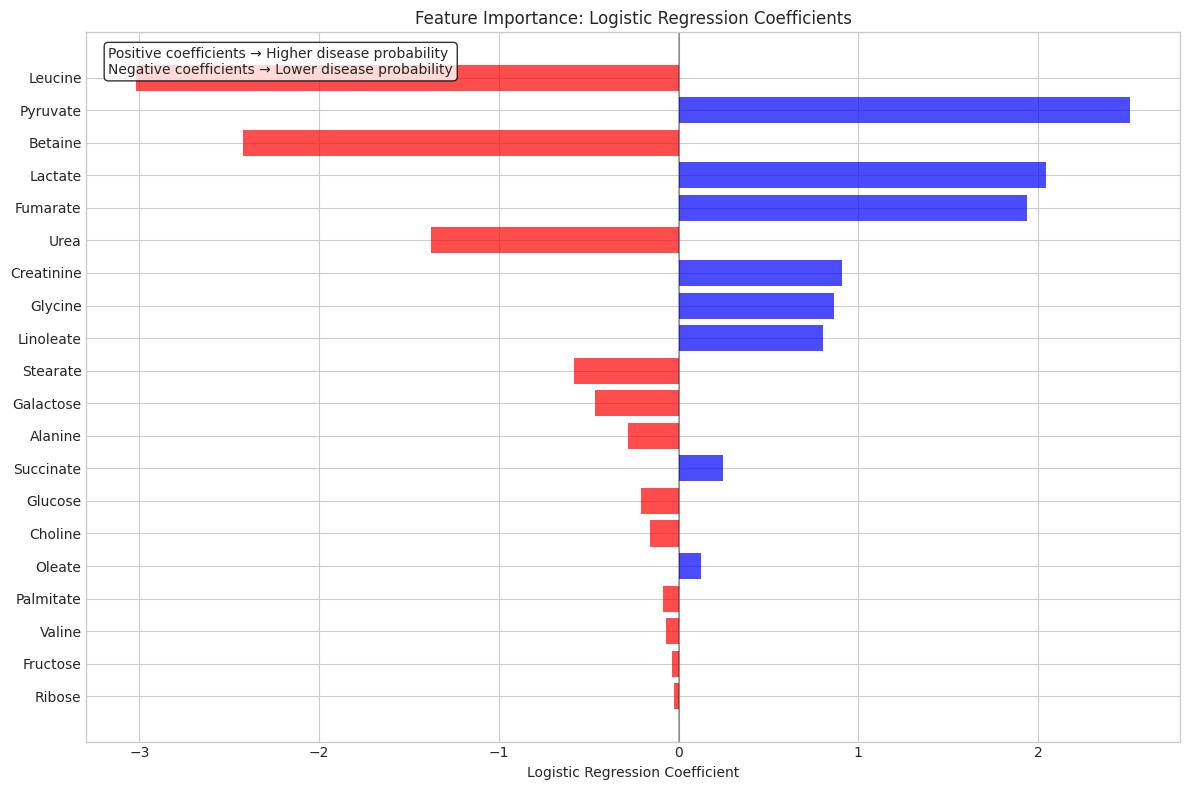

Logistic Regression Accuracy: 0.985

Model Equation (simplified):
P(Disease) = 1 / (1 + exp(-(-1.080 + Σ(coef_i × metabolite_i))))

Top 3 metabolites associated with DISEASE:
  Pyruvate: 2.513
  Lactate: 2.046
  Fumarate: 1.935

Top 3 metabolites associated with HEALTH:
  Leucine: -3.018
  Betaine: -2.424
  Urea: -1.378


In [27]:
# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Get coefficients
coefficients = lr_model.coef_[0]
intercept = lr_model.intercept_[0]

# Create coefficient DataFrame
coef_df = pd.DataFrame({
    'Metabolite': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=True)

# Visualize coefficients
plt.figure(figsize=(12, 8))
colors = ['red' if c < 0 else 'blue' for c in coef_df['Coefficient']]
bars = plt.barh(coef_df['Metabolite'], coef_df['Coefficient'], color=colors, alpha=0.7)

plt.xlabel('Logistic Regression Coefficient')
plt.title('Feature Importance: Logistic Regression Coefficients')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add interpretation text
plt.text(0.02, 0.98, 
         'Positive coefficients → Higher disease probability\n' +
         'Negative coefficients → Lower disease probability',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print model performance and interpretation
lr_accuracy = accuracy_score(y_test, lr_model.predict(X_test_scaled))
print(f"Logistic Regression Accuracy: {lr_accuracy:.3f}")
print(f"\nModel Equation (simplified):")
print(f"P(Disease) = 1 / (1 + exp(-({intercept:.3f} + Σ(coef_i × metabolite_i))))")

# Top positive and negative features
print(f"\nTop 3 metabolites associated with DISEASE:")
top_positive = coef_df.nlargest(3, 'Coefficient')
for _, row in top_positive.iterrows():
    print(f"  {row['Metabolite']}: {row['Coefficient']:.3f}")

print(f"\nTop 3 metabolites associated with HEALTH:")
top_negative = coef_df.nsmallest(3, 'Coefficient')
for _, row in top_negative.iterrows():
    print(f"  {row['Metabolite']}: {row['Coefficient']:.3f}")

### 2.2 Decision Tree: Rule Extraction

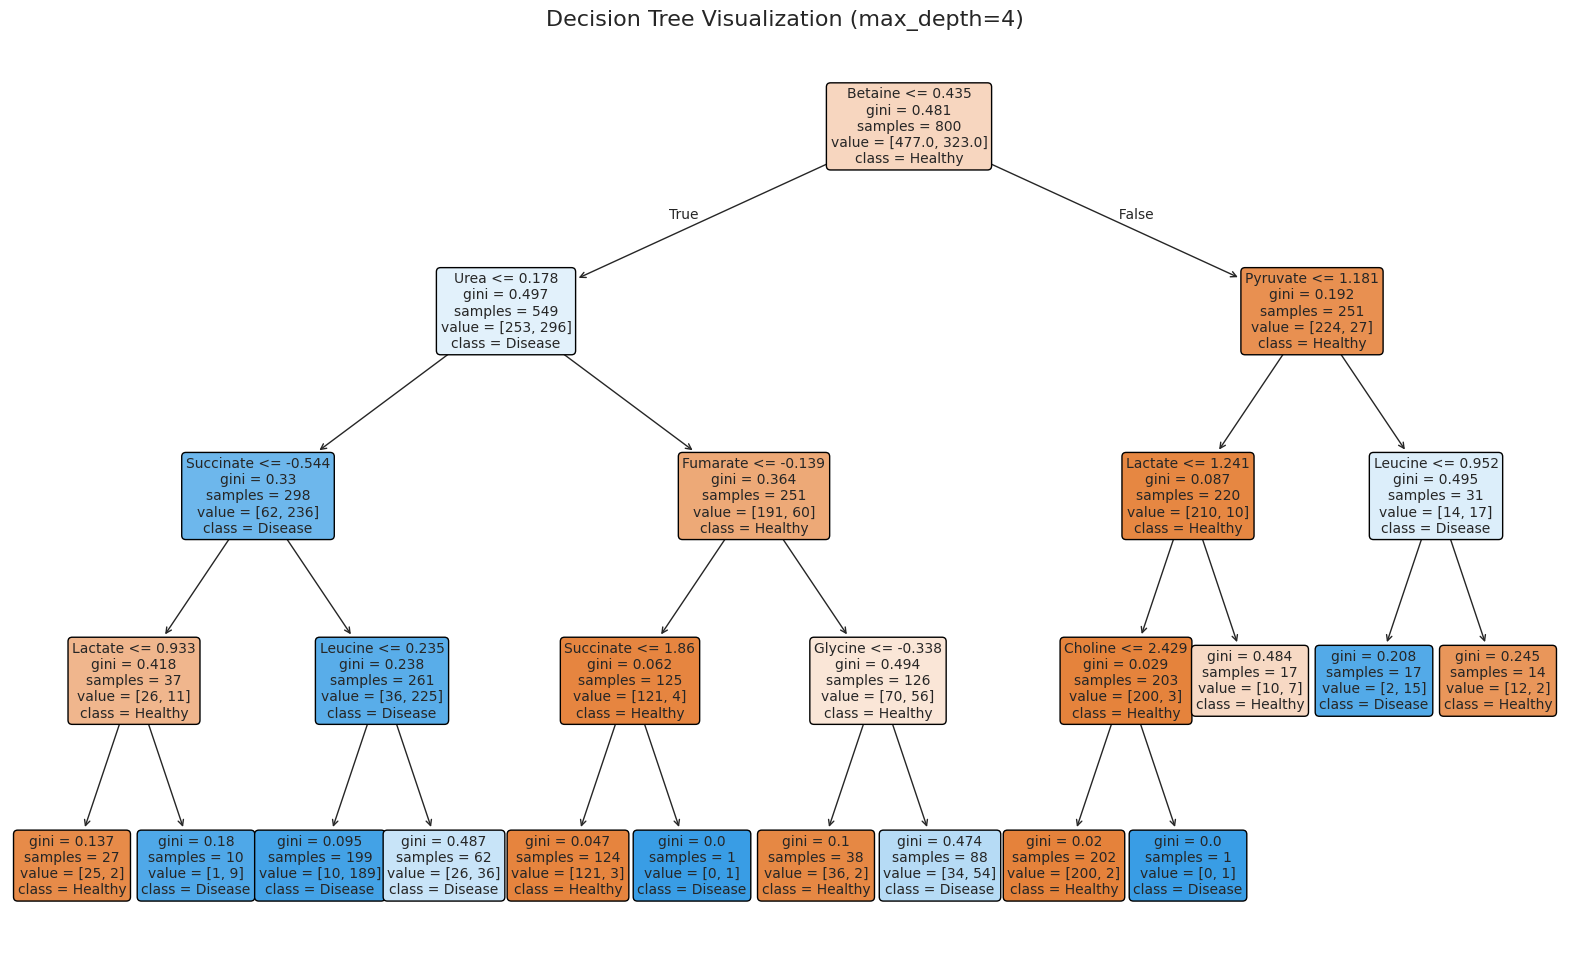

Decision Tree Rules:
Rule 1:
  IF Betaine <= 0.435 AND Urea <= 0.178 AND Succinate <= -0.544 AND Lactate <= 0.933
  THEN Prediction: Healthy
  Confidence: 0.926
  Training samples: 1

Rule 2:
  IF Betaine <= 0.435 AND Urea <= 0.178 AND Succinate <= -0.544 AND Lactate > 0.933
  THEN Prediction: Disease
  Confidence: 0.900
  Training samples: 1

Rule 3:
  IF Betaine <= 0.435 AND Urea <= 0.178 AND Succinate > -0.544 AND Leucine <= 0.235
  THEN Prediction: Disease
  Confidence: 0.950
  Training samples: 1

Rule 4:
  IF Betaine <= 0.435 AND Urea <= 0.178 AND Succinate > -0.544 AND Leucine > 0.235
  THEN Prediction: Disease
  Confidence: 0.581
  Training samples: 1

Rule 5:
  IF Betaine <= 0.435 AND Urea > 0.178 AND Fumarate <= -0.139 AND Succinate <= 1.860
  THEN Prediction: Healthy
  Confidence: 0.976
  Training samples: 1

Rule 6:
  IF Betaine <= 0.435 AND Urea > 0.178 AND Fumarate <= -0.139 AND Succinate > 1.860
  THEN Prediction: Disease
  Confidence: 1.000
  Training samples: 1

Rule 7

In [16]:
# Train a simple decision tree for interpretability
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42, min_samples_split=20)
dt_model.fit(X_train_scaled, y_train)

# Visualize the decision tree
plt.figure(figsize=(20, 12))
plot_tree(dt_model, 
          feature_names=feature_names,
          class_names=['Healthy', 'Disease'],
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Visualization (max_depth=4)', fontsize=16)
plt.show()

# Extract decision rules
def extract_rules(tree, feature_names, class_names):
    """
    Extract human-readable rules from a decision tree.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []
    
    def recurse(node, rule_conditions):
        if tree_.feature[node] != -2:  # Not a leaf
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # Left child (<=)
            left_conditions = rule_conditions + [f"{name} <= {threshold:.3f}"]
            recurse(tree_.children_left[node], left_conditions)
            
            # Right child (>)
            right_conditions = rule_conditions + [f"{name} > {threshold:.3f}"]
            recurse(tree_.children_right[node], right_conditions)
        else:  # Leaf node
            # Get the class prediction
            class_counts = tree_.value[node][0]
            predicted_class = np.argmax(class_counts)
            confidence = class_counts[predicted_class] / np.sum(class_counts)
            
            rule = {
                'conditions': ' AND '.join(rule_conditions),
                'prediction': class_names[predicted_class],
                'confidence': confidence,
                'samples': int(np.sum(class_counts))
            }
            rules.append(rule)
    
    recurse(0, [])
    return rules

# Extract and display rules
rules = extract_rules(dt_model, feature_names, ['Healthy', 'Disease'])

print("Decision Tree Rules:")
print("=" * 80)
for i, rule in enumerate(rules, 1):
    print(f"Rule {i}:")
    print(f"  IF {rule['conditions']}")
    print(f"  THEN Prediction: {rule['prediction']}")
    print(f"  Confidence: {rule['confidence']:.3f}")
    print(f"  Training samples: {rule['samples']}")
    print()

# Model performance
dt_accuracy = accuracy_score(y_test, dt_model.predict(X_test_scaled))
print(f"Decision Tree Accuracy: {dt_accuracy:.3f}")

## 3. Feature Importance for Black Box Models

For more complex models, we need specialized techniques to understand feature importance.

### 3.1 Random Forest Feature Importance

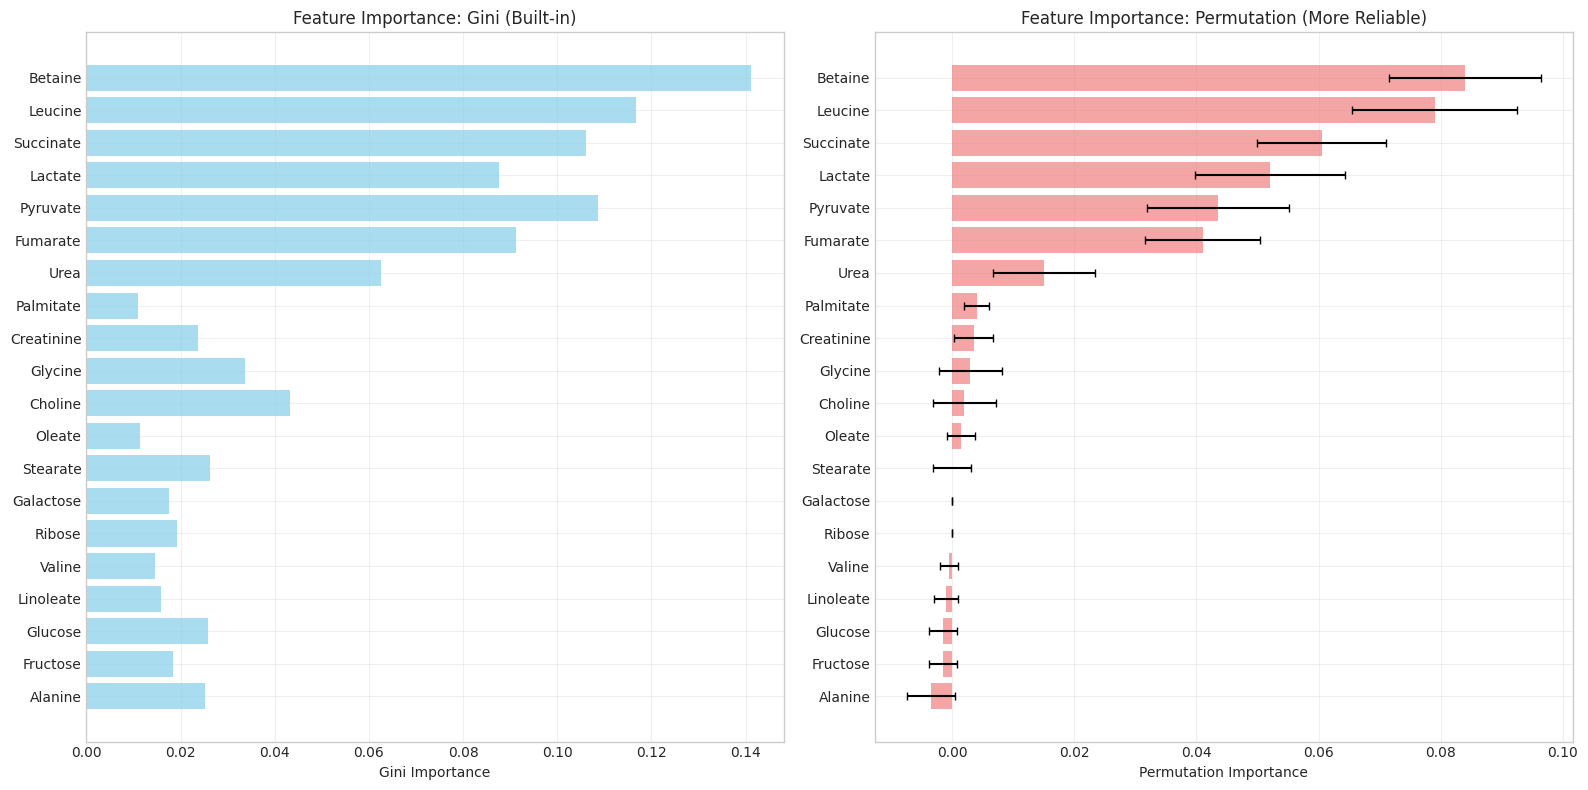

Random Forest Accuracy: 0.965

Top 5 Most Important Features (Permutation):
  Betaine: 0.0840 ± 0.0124
  Leucine: 0.0790 ± 0.0136
  Succinate: 0.0605 ± 0.0106
  Lactate: 0.0520 ± 0.0123
  Pyruvate: 0.0435 ± 0.0116

Importance by Metabolite Category:
  Organic_Acids: 0.1970
  Others: 0.1045
  Amino_Acids: 0.0780
  Lipids: 0.0045
  Sugars: -0.0030


In [17]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get built-in feature importance (Gini importance)
gini_importance = rf_model.feature_importances_

# Calculate permutation importance (more reliable)
perm_importance = permutation_importance(
    rf_model, X_test_scaled, y_test, n_repeats=10, random_state=42
)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Metabolite': feature_names,
    'Gini_Importance': gini_importance,
    'Permutation_Importance': perm_importance.importances_mean,
    'Permutation_Std': perm_importance.importances_std
})

# Sort by permutation importance
importance_df = importance_df.sort_values('Permutation_Importance', ascending=True)

# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gini importance
axes[0].barh(importance_df['Metabolite'], importance_df['Gini_Importance'], 
            alpha=0.7, color='skyblue')
axes[0].set_xlabel('Gini Importance')
axes[0].set_title('Feature Importance: Gini (Built-in)')
axes[0].grid(alpha=0.3)

# Permutation importance
axes[1].barh(importance_df['Metabolite'], importance_df['Permutation_Importance'], 
            xerr=importance_df['Permutation_Std'], alpha=0.7, color='lightcoral', capsize=3)
axes[1].set_xlabel('Permutation Importance')
axes[1].set_title('Feature Importance: Permutation (More Reliable)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print top features
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test_scaled))
print(f"Random Forest Accuracy: {rf_accuracy:.3f}")

print(f"\nTop 5 Most Important Features (Permutation):")
top_features = importance_df.nlargest(5, 'Permutation_Importance')
for _, row in top_features.iterrows():
    print(f"  {row['Metabolite']}: {row['Permutation_Importance']:.4f} ± {row['Permutation_Std']:.4f}")

# Feature importance by metabolite category
category_importance = {}
for category, metabolites in metabolite_categories.items():
    category_scores = importance_df[importance_df['Metabolite'].isin(metabolites)]['Permutation_Importance']
    category_importance[category] = category_scores.sum()

print(f"\nImportance by Metabolite Category:")
for category, score in sorted(category_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"  {category}: {score:.4f}")

## 4. SHAP (Shapley Additive Explanations)

SHAP provides a unified framework for interpreting model predictions by attributing the contribution of each feature to individual predictions.

### 4.1 SHAP for Tree-based Models

<Figure size 1000x800 with 0 Axes>

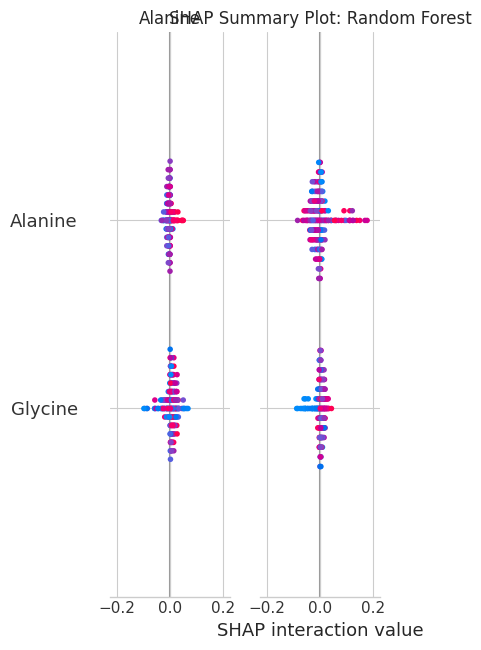

<Figure size 1000x800 with 0 Axes>

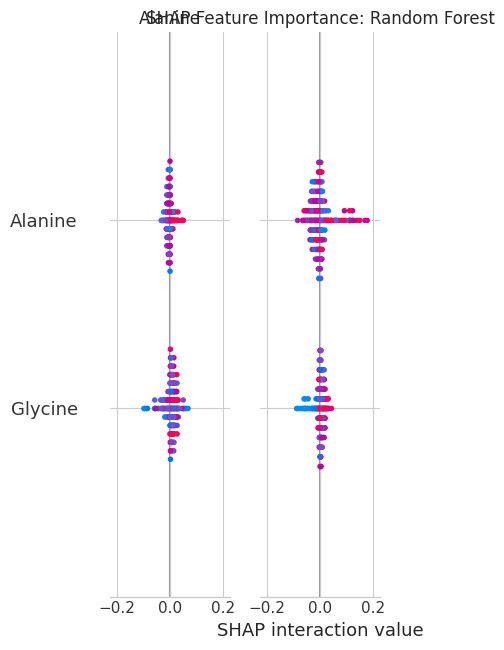

SHAP Summary Plot Interpretation:
• Each dot represents one sample from the test set
• X-axis shows SHAP value (impact on model output)
• Color represents feature value (red=high, blue=low)
• Features are ordered by importance (top to bottom)


In [18]:
# Create SHAP explainer for Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# SHAP returns values for both classes, we'll use class 1 (Disease)
if len(shap_values_rf) == 2:  # Binary classification
    shap_values_disease = shap_values_rf[1]
else:
    shap_values_disease = shap_values_rf

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_disease, X_test_df, show=False)
plt.title('SHAP Summary Plot: Random Forest')
plt.tight_layout()
plt.show()

# Feature importance (mean absolute SHAP values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_disease, X_test_df, plot_type="bar", show=False)
plt.title('SHAP Feature Importance: Random Forest')
plt.tight_layout()
plt.show()

print("SHAP Summary Plot Interpretation:")
print("• Each dot represents one sample from the test set")
print("• X-axis shows SHAP value (impact on model output)")
print("• Color represents feature value (red=high, blue=low)")
print("• Features are ordered by importance (top to bottom)")

### 4.2 Individual Prediction Explanations

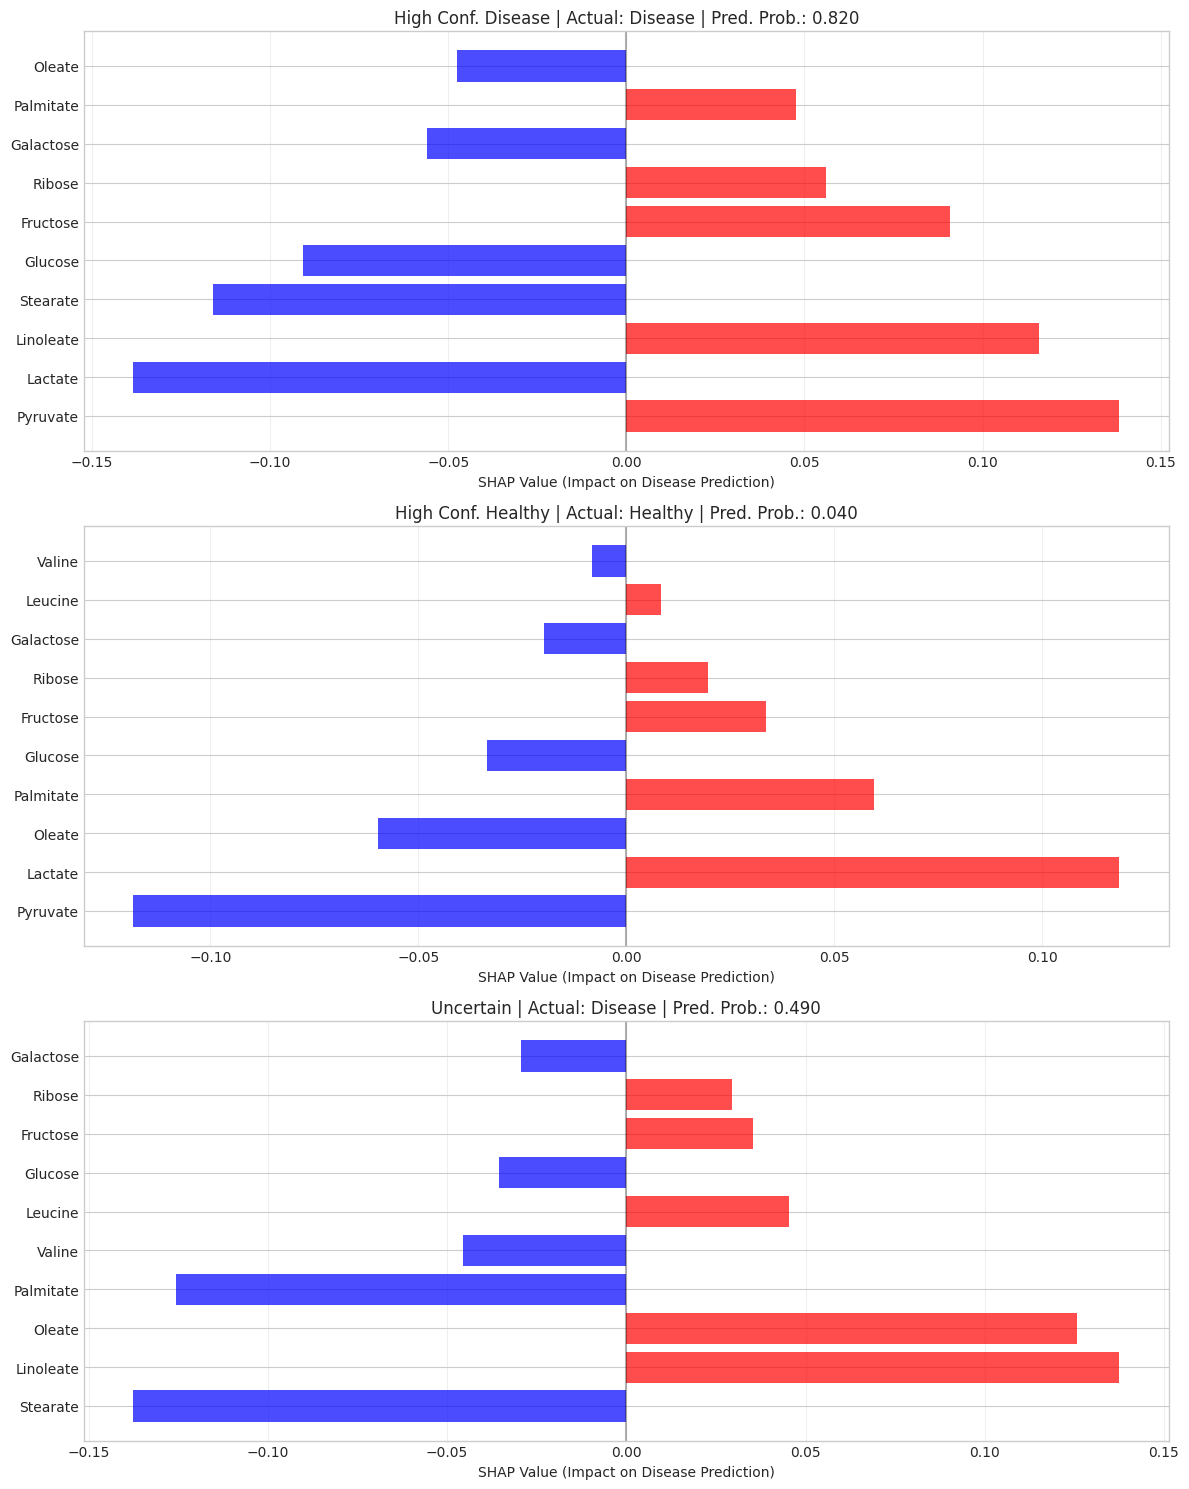

Individual Prediction Explanation:
• Red bars: Features pushing prediction toward Disease
• Blue bars: Features pushing prediction toward Healthy
• Longer bars indicate stronger influence on the prediction


In [19]:
# Select interesting samples for detailed explanation
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Find samples with different prediction confidence levels
high_confidence_disease = np.where((y_pred_proba > 0.8) & (y_test == 1))[0]
high_confidence_healthy = np.where((y_pred_proba < 0.2) & (y_test == 0))[0]
uncertain_predictions = np.where((y_pred_proba > 0.4) & (y_pred_proba < 0.6))[0]

# Select one sample from each category with bounds checking
sample_indices = []
if len(high_confidence_disease) > 0:
    sample_indices.append(high_confidence_disease[0])
elif len(y_test) > 0:
    sample_indices.append(0)

if len(high_confidence_healthy) > 0:
    sample_indices.append(high_confidence_healthy[0])
elif len(y_test) > 1:
    sample_indices.append(1)

if len(uncertain_predictions) > 0:
    sample_indices.append(uncertain_predictions[0])
elif len(y_test) > 2:
    sample_indices.append(2)

# Ensure we have at least one sample
if not sample_indices:
    sample_indices = [0]

sample_types = ['High Conf. Disease', 'High Conf. Healthy', 'Uncertain'][:len(sample_indices)]

# Create individual explanation plots using bar plots (more reliable than waterfall)
fig, axes = plt.subplots(len(sample_indices), 1, figsize=(12, 5*len(sample_indices)))
if len(sample_indices) == 1:
    axes = [axes]

for i, (idx, sample_type) in enumerate(zip(sample_indices, sample_types)):
    if idx >= len(X_test_df):
        continue
        
    # Get SHAP values for this sample
    sample_shap_values = shap_values_disease[idx]
    sample_features = X_test_df.iloc[idx]
    
    # Ensure arrays are 1D and same length
    shap_vals = np.array(sample_shap_values).flatten()
    feature_vals = np.array(sample_features).flatten()
    feat_names = np.array(feature_names).flatten()
    
    # Ensure all arrays have the same length
    min_len = min(len(shap_vals), len(feature_vals), len(feat_names))
    shap_vals = shap_vals[:min_len]
    feature_vals = feature_vals[:min_len]
    feat_names = feat_names[:min_len]
    
    # Get top 10 most influential features
    feature_importance = pd.DataFrame({
        'Feature': feat_names,
        'SHAP_Value': shap_vals,
        'Feature_Value': feature_vals
    })
    
    top_features = feature_importance.reindex(
        feature_importance['SHAP_Value'].abs().nlargest(min(10, len(feature_importance))).index
    )
    
    # Create bar plot
    colors = ['red' if x > 0 else 'blue' for x in top_features['SHAP_Value']]
    axes[i].barh(top_features['Feature'], top_features['SHAP_Value'], color=colors, alpha=0.7)
    axes[i].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    axes[i].set_xlabel('SHAP Value (Impact on Disease Prediction)')
    
    # Add prediction information
    pred_proba = y_pred_proba[idx]
    actual_class = 'Disease' if y_test[idx] == 1 else 'Healthy'
    axes[i].set_title(f'{sample_type} | Actual: {actual_class} | Pred. Prob.: {pred_proba:.3f}')
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Individual Prediction Explanation:")
print("• Red bars: Features pushing prediction toward Disease")
print("• Blue bars: Features pushing prediction toward Healthy")
print("• Longer bars indicate stronger influence on the prediction")

### 4.3 SHAP for Linear Models

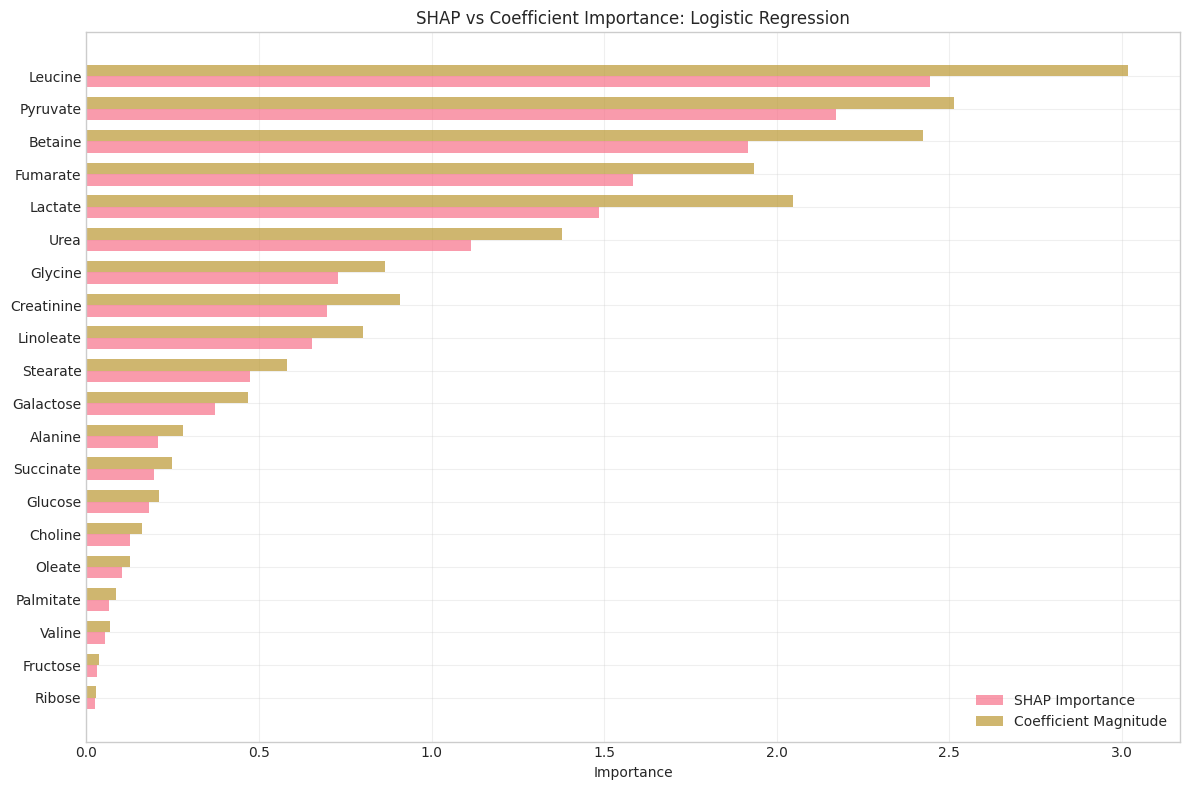

Correlation between SHAP importance and coefficient magnitude: 0.998
(High correlation expected for linear models)


In [20]:
# Create SHAP explainer for Logistic Regression
explainer_lr = shap.LinearExplainer(lr_model, X_train_scaled)
shap_values_lr = explainer_lr.shap_values(X_test_scaled)

# Compare SHAP values with coefficients
plt.figure(figsize=(12, 8))

# Calculate mean absolute SHAP values
mean_shap_values = np.abs(shap_values_lr).mean(axis=0)
mean_abs_coefficients = np.abs(lr_model.coef_[0])

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Metabolite': feature_names,
    'SHAP_Importance': mean_shap_values,
    'Coefficient_Magnitude': mean_abs_coefficients
})

comparison_df = comparison_df.sort_values('SHAP_Importance', ascending=True)

# Create side-by-side bar plot
x = np.arange(len(comparison_df))
width = 0.35

plt.barh(x - width/2, comparison_df['SHAP_Importance'], width, 
         label='SHAP Importance', alpha=0.7)
plt.barh(x + width/2, comparison_df['Coefficient_Magnitude'], width, 
         label='Coefficient Magnitude', alpha=0.7)

plt.xlabel('Importance')
plt.title('SHAP vs Coefficient Importance: Logistic Regression')
plt.yticks(x, comparison_df['Metabolite'])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation between SHAP and coefficients
correlation = np.corrcoef(mean_shap_values, mean_abs_coefficients)[0, 1]
print(f"Correlation between SHAP importance and coefficient magnitude: {correlation:.3f}")
print("(High correlation expected for linear models)")

## 5. Dependency Plots and Feature Interactions

SHAP dependency plots show how individual features affect predictions and reveal feature interactions.

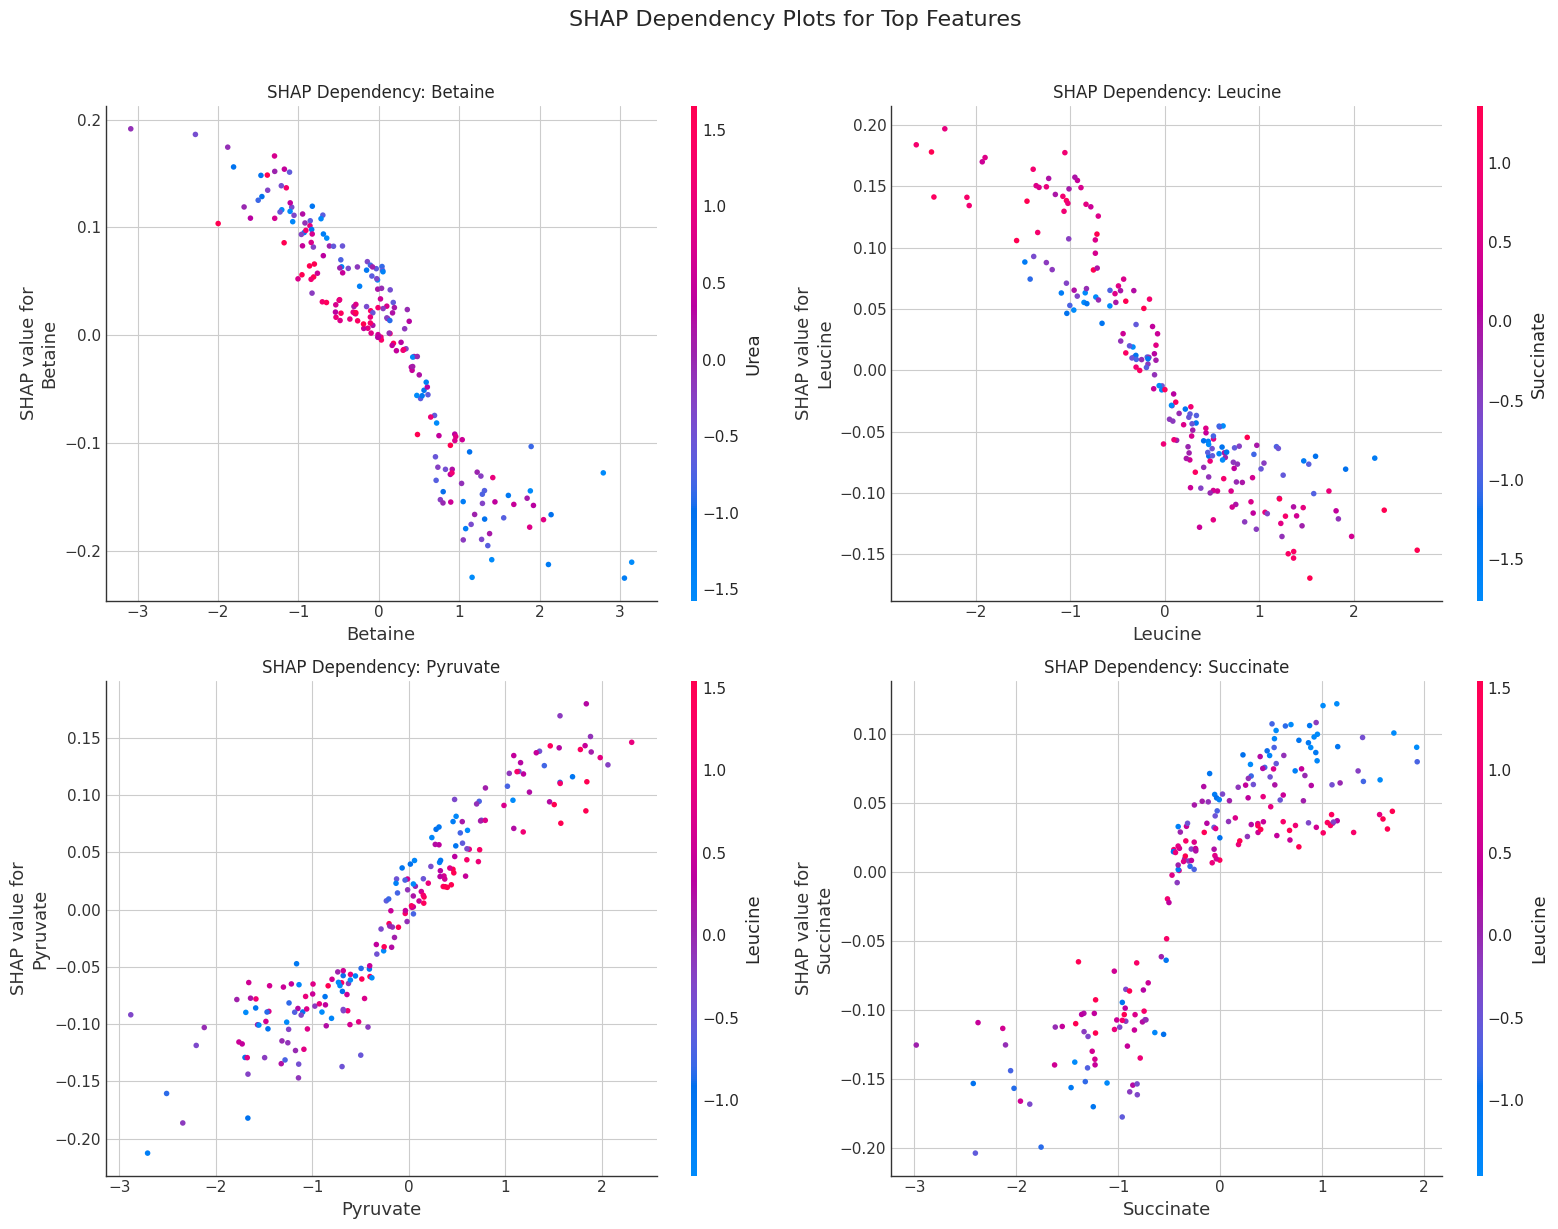

In [21]:
# Use SHAP values for class 1 (or change to 0 if needed)
shap_values_single_class = shap_values_disease[:, :, 1]

# Compute mean absolute SHAP values and get top features
mean_abs_shap = np.abs(shap_values_single_class).mean(axis=0).ravel()
feature_importance_order = np.argsort(mean_abs_shap)[::-1]
valid_indices = [i for i in feature_importance_order if i < len(feature_names)]
top_4_indices = valid_indices[:4]

# Plot all four SHAP dependency plots as subplots in a single figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Remove colorbars after the first plot to avoid duplicate colorbars
for i, feature_idx in enumerate(top_4_indices):
    feature_name = feature_names[feature_idx]
    axes[i].cla()  # Clear axis in case of overlap
    shap.dependence_plot(
        feature_name,
        shap_values_single_class,  # now 2D
        X_test_df,
        interaction_index="auto",
        ax=axes[i],
        show=False,
        color=None if i == 0 else plt.cm.Blues  # Only show colorbar for first plot
    )
    axes[i].set_title(f'SHAP Dependency: {feature_name}', fontsize=12)

plt.suptitle('SHAP Dependency Plots for Top Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#### How to Interpret the SHAP Dependency Plots Above
Each subplot shows how a top feature influences the model's prediction for disease status. The x-axis is the feature value, the y-axis is the SHAP value (impact on prediction), and color indicates interaction with another feature. Patterns or trends reveal whether higher or lower values of a metabolite increase disease risk, and if there are interactions with other metabolites. Use these plots to identify non-linear effects and feature interactions that drive model decisions.

## 6. Model Comparison Through Interpretability

Let's compare how different models interpret the same data.

Training and explaining Logistic Regression...
Training and explaining Random Forest...
  Raw SHAP shape for Random Forest: (200, 20, 2)
  Final SHAP shape for Random Forest: (200, 20)
Training and explaining Gradient Boosting...
  Raw SHAP shape for Random Forest: (200, 20, 2)
  Final SHAP shape for Random Forest: (200, 20)
Training and explaining Gradient Boosting...
  Raw SHAP shape for Gradient Boosting: (200, 20)
  Final SHAP shape for Gradient Boosting: (200, 20)
Processing Logistic Regression with SHAP values shape: (200, 20)
  Mean importance shape: (20,)
Processing Random Forest with SHAP values shape: (200, 20)
  Mean importance shape: (20,)
Processing Gradient Boosting with SHAP values shape: (200, 20)
  Mean importance shape: (20,)
  Raw SHAP shape for Gradient Boosting: (200, 20)
  Final SHAP shape for Gradient Boosting: (200, 20)
Processing Logistic Regression with SHAP values shape: (200, 20)
  Mean importance shape: (20,)
Processing Random Forest with SHAP values shape:

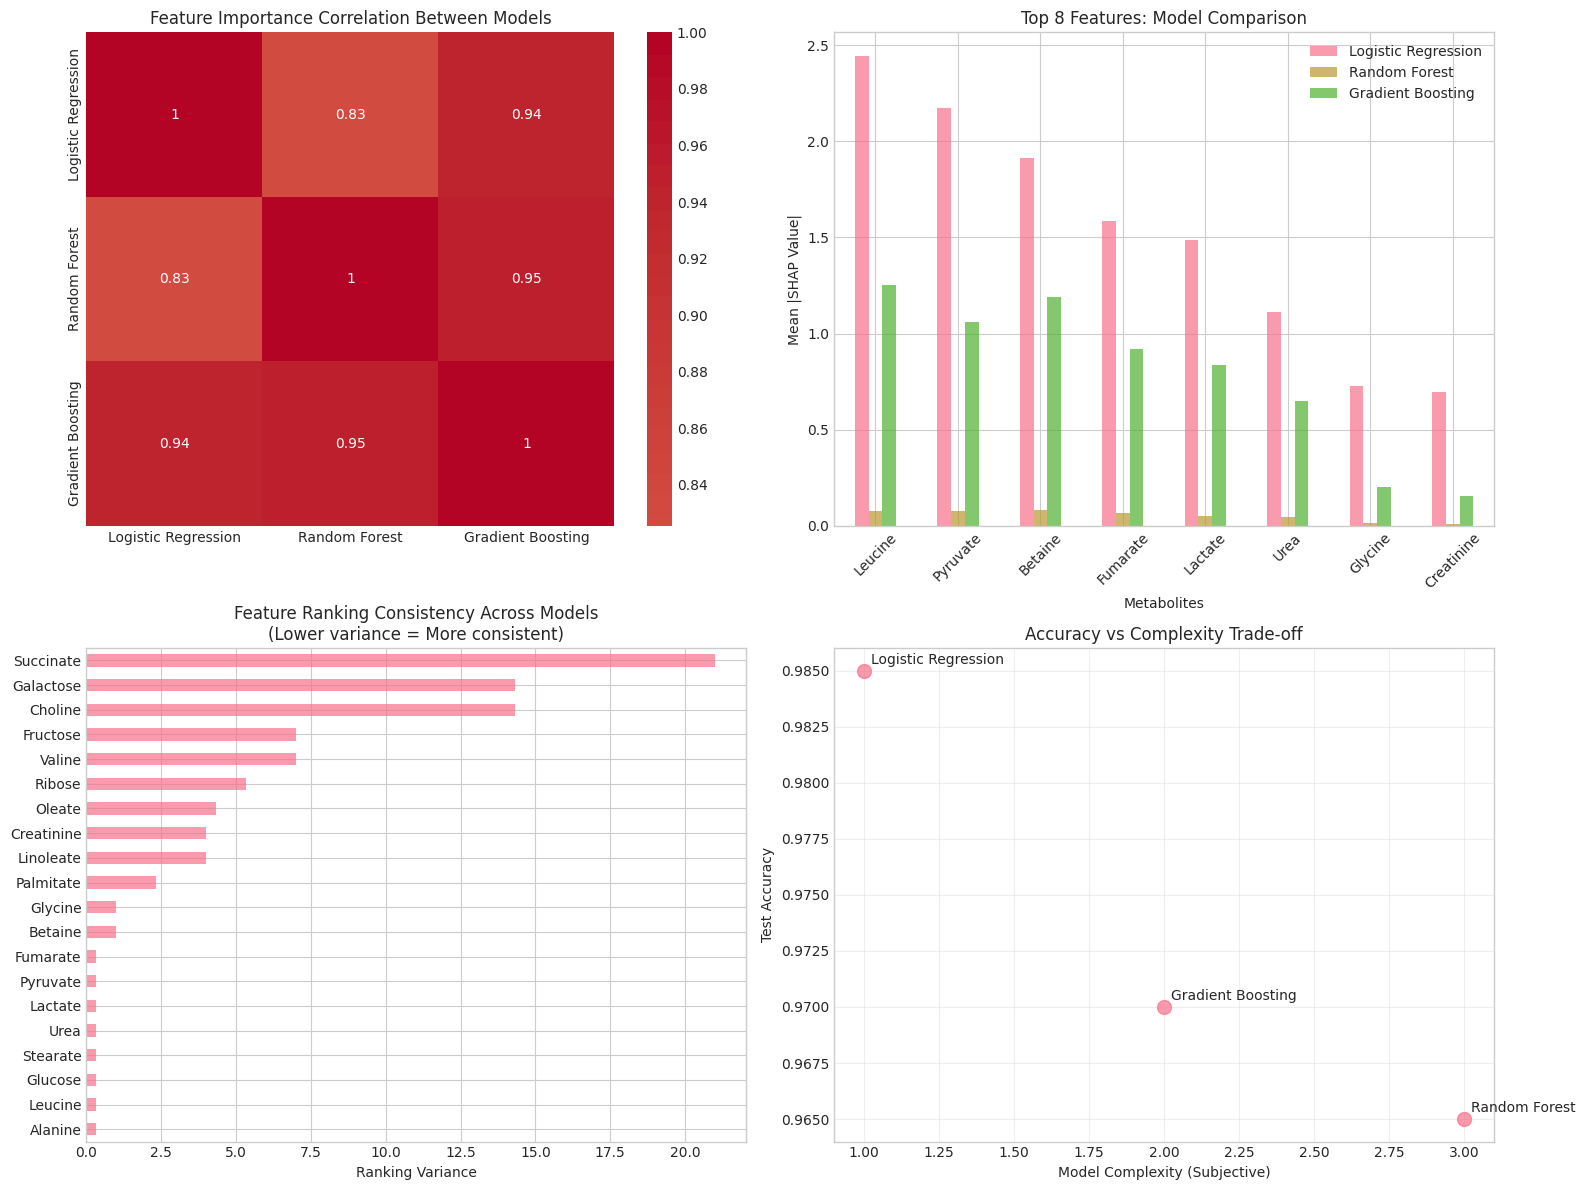


Model Performance and Agreement Analysis:
Logistic Regression: 0.985 accuracy
Random Forest: 0.965 accuracy
Gradient Boosting: 0.970 accuracy

Feature importance correlation between models:
  Logistic Regression vs Random Forest: 0.825
  Logistic Regression vs Gradient Boosting: 0.945
  Random Forest vs Gradient Boosting: 0.953

Most consistent features across models:
  Alanine: variance = 0.33
  Leucine: variance = 0.33
  Stearate: variance = 0.33
  Glucose: variance = 0.33
  Lactate: variance = 0.33

Least consistent features across models:
  Succinate: variance = 21.00
  Galactose: variance = 14.33
  Choline: variance = 14.33
  Valine: variance = 7.00
  Fructose: variance = 7.00


In [22]:
# Train multiple models for comparison
models_to_compare = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train models and get SHAP values
model_shap_values = {}
model_accuracies = {}

for name, model in models_to_compare.items():
    print(f"Training and explaining {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)
    model_accuracies[name] = accuracy_score(y_test, model.predict(X_test_scaled))

    # Get SHAP values
    if name == 'Logistic Regression':
        masker = shap.maskers.Independent(X_train_scaled)
        explainer = shap.LinearExplainer(model, masker)
        shap_values = explainer(X_test_scaled).values  # shape: (n_samples, n_features)
    else:
        explainer = shap.TreeExplainer(model)
        raw_shap = explainer.shap_values(X_test_scaled)
        
        # Debug: print the shape to understand the structure
        print(f"  Raw SHAP shape for {name}: {np.array(raw_shap).shape if isinstance(raw_shap, list) else raw_shap.shape}")
        
        # Handle different SHAP output formats more robustly
        if isinstance(raw_shap, list):
            # For binary classification, we want the positive class (index 1)
            if len(raw_shap) == 2:
                shap_values = raw_shap[1]  # class 1 (positive class)
            else:
                shap_values = raw_shap[0]  # fallback to first class
        else:
            # Handle numpy array cases
            if raw_shap.ndim == 3:
                # Shape: (n_samples, n_features, n_classes) or (n_samples, n_classes, n_features)
                if raw_shap.shape[2] == 2:
                    # Shape is (n_samples, n_features, n_classes)
                    shap_values = raw_shap[:, :, 1]  # select positive class
                elif raw_shap.shape[1] == 2:
                    # Shape is (n_samples, n_classes, n_features) - less common
                    shap_values = raw_shap[:, 1, :]  # select positive class
                else:
                    # Fallback - take the last dimension if it looks like classes
                    if raw_shap.shape[2] < raw_shap.shape[1]:
                        shap_values = raw_shap[:, :, -1]  # last class
                    else:
                        shap_values = raw_shap[:, -1, :]  # last class
            elif raw_shap.ndim == 2:
                # Already in correct format: (n_samples, n_features)
                shap_values = raw_shap
            else:
                raise ValueError(f"Unexpected SHAP values shape: {raw_shap.shape}")
        
        # Ensure we have the right shape
        print(f"  Final SHAP shape for {name}: {shap_values.shape}")
        
        # Verify it's 2D with correct dimensions
        if shap_values.ndim != 2:
            raise ValueError(f"SHAP values should be 2D, got {shap_values.ndim}D with shape {shap_values.shape}")

    model_shap_values[name] = shap_values

# Compare feature importance across models
importance_comparison = pd.DataFrame()

for name, shap_values in model_shap_values.items():
    print(f"Processing {name} with SHAP values shape: {shap_values.shape}")
    mean_importance = np.abs(shap_values).mean(axis=0)
    print(f"  Mean importance shape: {mean_importance.shape}")
    importance_comparison[name] = mean_importance

importance_comparison.index = feature_names

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Correlation matrix of feature importance
correlation_matrix = importance_comparison.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,0])
axes[0,0].set_title('Feature Importance Correlation Between Models')

# Top features comparison
top_n = 8
top_features_overall = importance_comparison.mean(axis=1).nlargest(top_n).index
top_importance_data = importance_comparison.loc[top_features_overall]

top_importance_data.plot(kind='bar', ax=axes[0,1], alpha=0.7)
axes[0,1].set_title(f'Top {top_n} Features: Model Comparison')
axes[0,1].set_xlabel('Metabolites')
axes[0,1].set_ylabel('Mean |SHAP Value|')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()

# Model agreement analysis
feature_rankings = {}
for model in importance_comparison.columns:
    ranking = importance_comparison[model].rank(ascending=False)
    feature_rankings[model] = ranking

ranking_df = pd.DataFrame(feature_rankings)
ranking_variance = ranking_df.var(axis=1)

# Plot ranking variance
ranking_variance.sort_values(ascending=True).plot(kind='barh', ax=axes[1,0], alpha=0.7)
axes[1,0].set_title('Feature Ranking Consistency Across Models\n(Lower variance = More consistent)')
axes[1,0].set_xlabel('Ranking Variance')

# Model accuracy vs interpretability
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())
complexity_scores = [1, 3, 2]  # Subjective complexity: LR=1, RF=3, GB=2

scatter = axes[1,1].scatter(complexity_scores, accuracies, s=100, alpha=0.7)
for i, name in enumerate(model_names):
    axes[1,1].annotate(name, (complexity_scores[i], accuracies[i]), 
                      xytext=(5, 5), textcoords='offset points')

axes[1,1].set_xlabel('Model Complexity (Subjective)')
axes[1,1].set_ylabel('Test Accuracy')
axes[1,1].set_title('Accuracy vs Complexity Trade-off')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print model agreement analysis
print("\nModel Performance and Agreement Analysis:")
print("=" * 50)
for name, accuracy in model_accuracies.items():
    print(f"{name}: {accuracy:.3f} accuracy")

print(f"\nFeature importance correlation between models:")
for i, model1 in enumerate(correlation_matrix.columns):
    for model2 in correlation_matrix.columns[i+1:]:
        corr = correlation_matrix.loc[model1, model2]
        print(f"  {model1} vs {model2}: {corr:.3f}")

print(f"\nMost consistent features across models:")
most_consistent = ranking_variance.nsmallest(5)
for feature, variance in most_consistent.items():
    print(f"  {feature}: variance = {variance:.2f}")

print(f"\nLeast consistent features across models:")
least_consistent = ranking_variance.nlargest(5)
for feature, variance in least_consistent.items():
    print(f"  {feature}: variance = {variance:.2f}")

## 7. Creating Interpretable Visualizations for Scientific Communication

Let's create publication-ready visualizations that effectively communicate model insights.

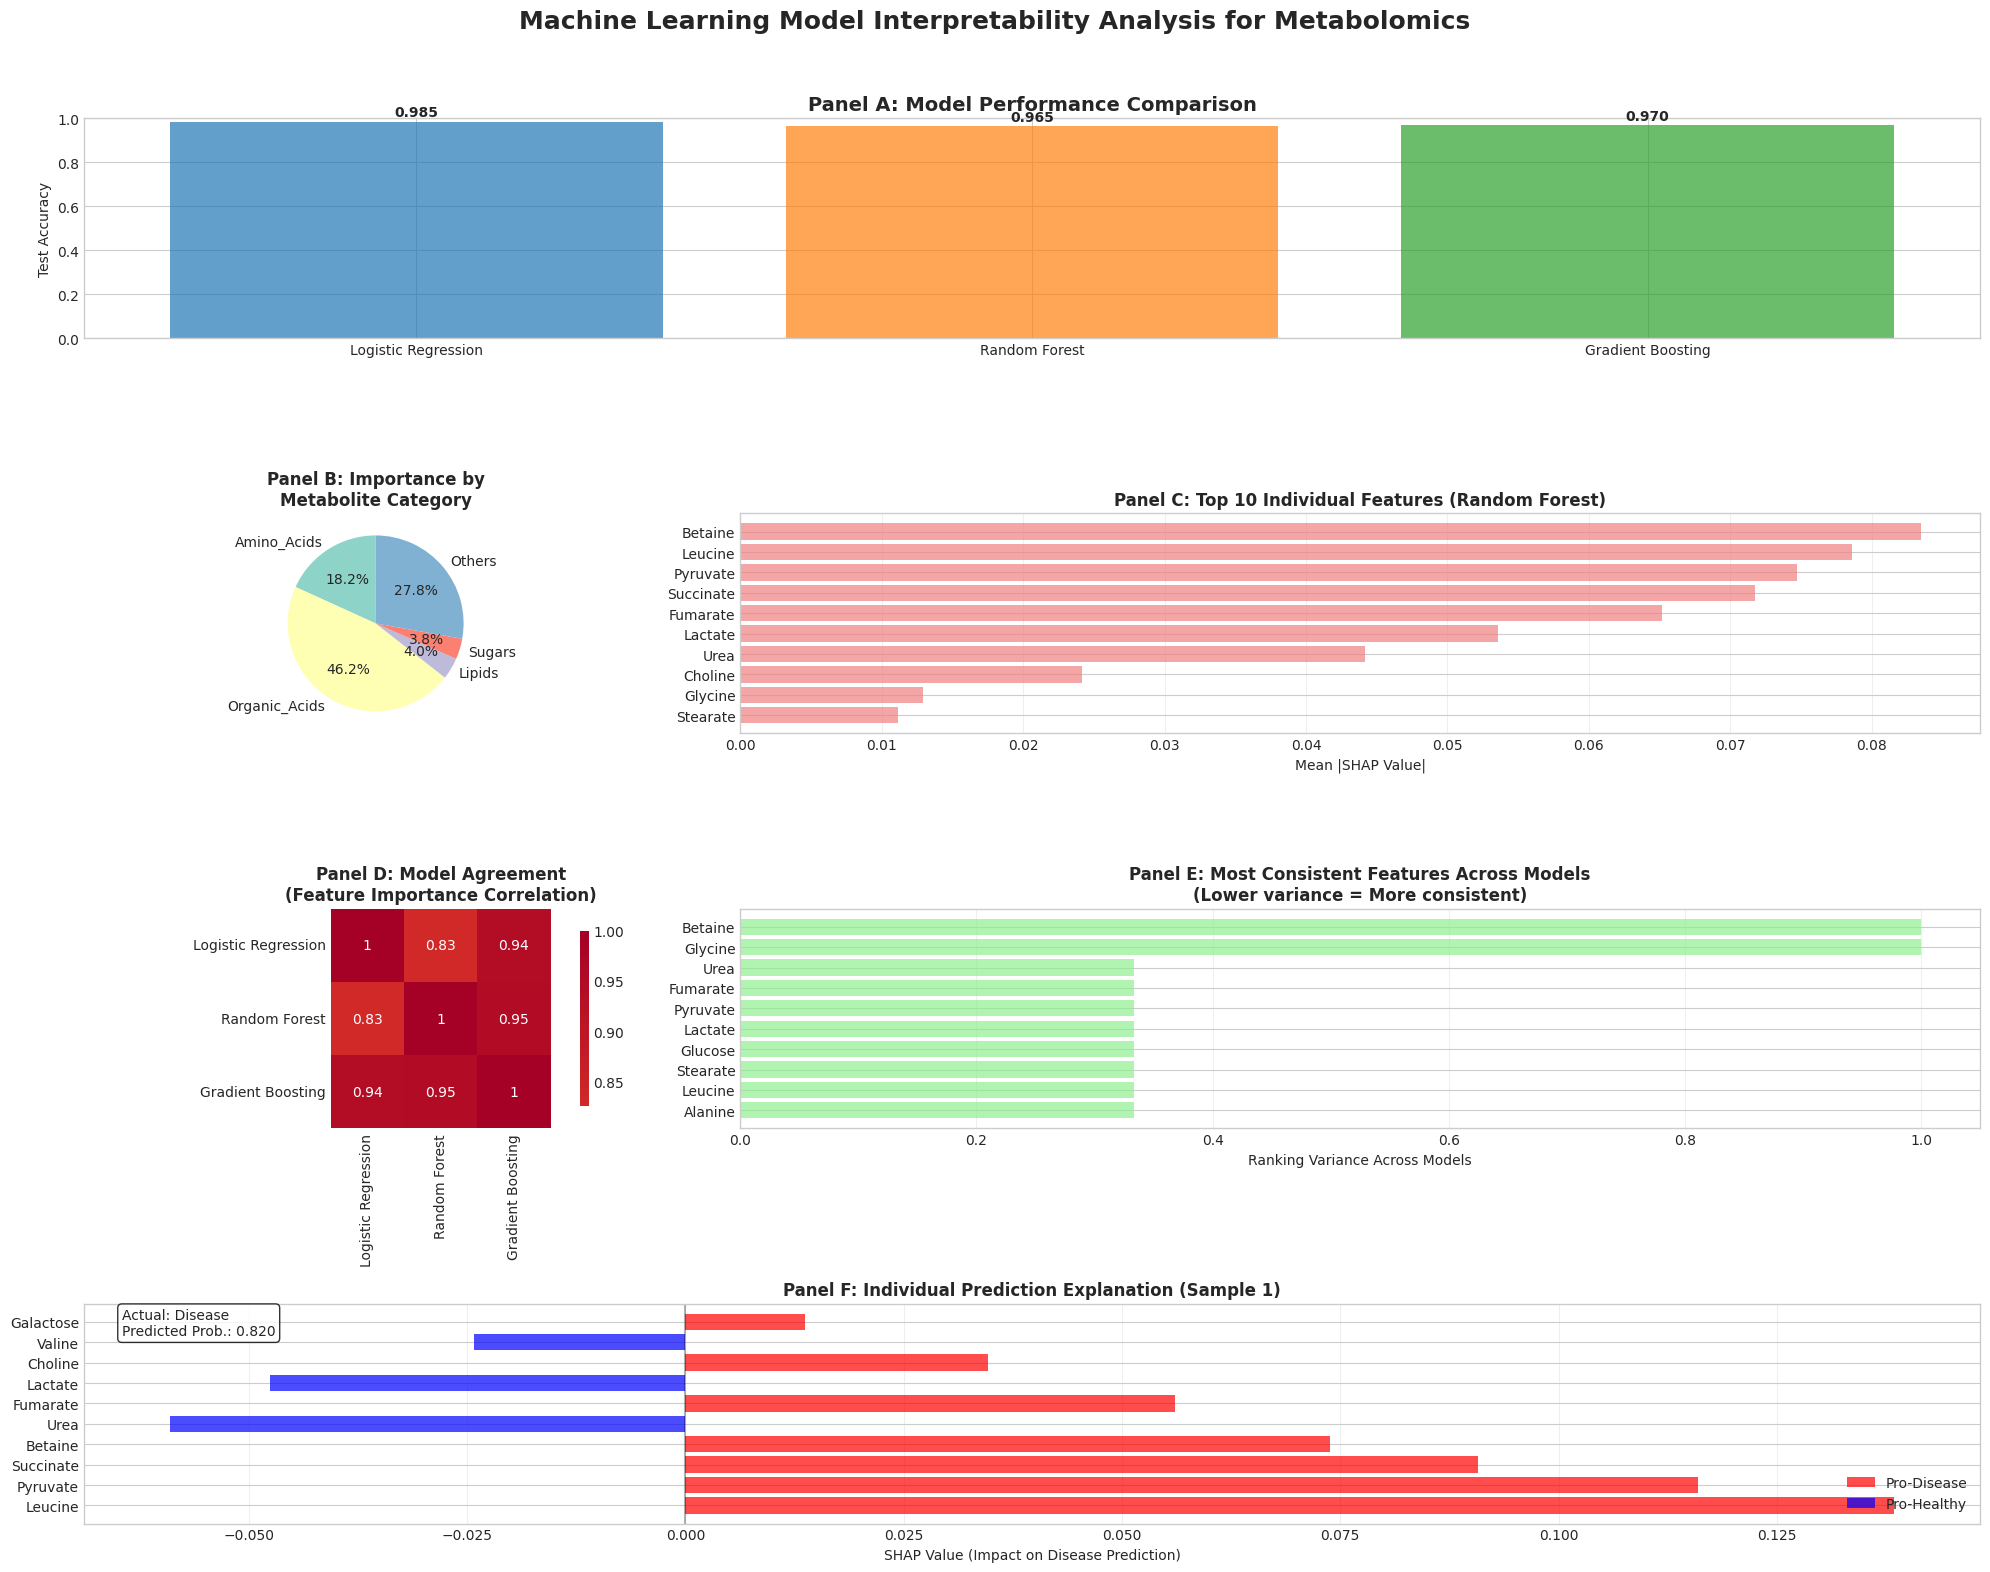


📊 Comprehensive interpretability figure saved as 'interpretability_analysis.png'


In [23]:
# Create a comprehensive interpretability figure
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1, 1])

# Panel A: Model Performance Comparison
ax1 = fig.add_subplot(gs[0, :])
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())
bars = ax1.bar(model_names, accuracies, alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Panel A: Model Performance Comparison', fontweight='bold', fontsize=14)
ax1.set_ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Panel B: Feature Importance by Category (Random Forest)
ax2 = fig.add_subplot(gs[1, 0])
rf_shap_values = model_shap_values['Random Forest']
category_shap_importance = {}

for category, metabolites in metabolite_categories.items():
    category_indices = [i for i, name in enumerate(feature_names) if name in metabolites]
    category_shap = np.abs(rf_shap_values[:, category_indices]).mean()
    category_shap_importance[category] = category_shap

categories = list(category_shap_importance.keys())
category_scores = list(category_shap_importance.values())

wedges, texts, autotexts = ax2.pie(category_scores, labels=categories, autopct='%1.1f%%',
                                   startangle=90, colors=plt.cm.Set3(range(len(categories))))
ax2.set_title('Panel B: Importance by\nMetabolite Category', fontweight='bold')

# Panel C: Top Individual Features
ax3 = fig.add_subplot(gs[1, 1:])
rf_importance = np.abs(rf_shap_values).mean(axis=0)
top_features_idx = np.argsort(rf_importance)[-10:]  # Top 10
top_features_names = [feature_names[i] for i in top_features_idx]
top_features_scores = rf_importance[top_features_idx]

bars = ax3.barh(top_features_names, top_features_scores, alpha=0.7, color='lightcoral')
ax3.set_xlabel('Mean |SHAP Value|')
ax3.set_title('Panel C: Top 10 Individual Features (Random Forest)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Panel D: Model Agreement Heatmap
ax4 = fig.add_subplot(gs[2, 0])
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, ax=ax4, cbar_kws={'shrink': 0.8})
ax4.set_title('Panel D: Model Agreement\n(Feature Importance Correlation)', fontweight='bold')

# Panel E: Feature Consistency
ax5 = fig.add_subplot(gs[2, 1:])
most_consistent_features = ranking_variance.nsmallest(10)
bars = ax5.barh(range(len(most_consistent_features)), most_consistent_features.values, 
                alpha=0.7, color='lightgreen')
ax5.set_yticks(range(len(most_consistent_features)))
ax5.set_yticklabels(most_consistent_features.index)
ax5.set_xlabel('Ranking Variance Across Models')
ax5.set_title('Panel E: Most Consistent Features Across Models\n(Lower variance = More consistent)', fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# Panel F: Individual Prediction Example
ax6 = fig.add_subplot(gs[3, :])

# Select a representative sample
sample_idx = 0
sample_shap = rf_shap_values[sample_idx]
sample_features = X_test_df.iloc[sample_idx]

# Get top contributing features (positive and negative)
feature_contributions = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Value': sample_shap,
    'Feature_Value': sample_features.values
})

# Select top 10 most influential features
top_contrib = feature_contributions.reindex(
    feature_contributions['SHAP_Value'].abs().nlargest(10).index
)

colors = ['red' if x > 0 else 'blue' for x in top_contrib['SHAP_Value']]
bars = ax6.barh(top_contrib['Feature'], top_contrib['SHAP_Value'], color=colors, alpha=0.7)

ax6.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax6.set_xlabel('SHAP Value (Impact on Disease Prediction)')
ax6.set_title(f'Panel F: Individual Prediction Explanation (Sample {sample_idx + 1})', fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

# Add prediction info
pred_proba = rf_model.predict_proba(X_test_scaled[sample_idx:sample_idx+1])[0, 1]
actual = 'Disease' if y_test[sample_idx] == 1 else 'Healthy'
ax6.text(0.02, 0.98, f'Actual: {actual}\nPredicted Prob.: {pred_proba:.3f}', 
         transform=ax6.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add color legend
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.7, label='Pro-Disease'),
    plt.Rectangle((0,0),1,1, facecolor='blue', alpha=0.7, label='Pro-Healthy')
]
ax6.legend(handles=legend_elements, loc='lower right')

plt.suptitle('Machine Learning Model Interpretability Analysis for Metabolomics', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Save the figure
fig.savefig('/home/chen/ml-metabolomics-tutorial/interpretability_analysis.png', 
            dpi=300, bbox_inches='tight')
print("\n📊 Comprehensive interpretability figure saved as 'interpretability_analysis.png'")

### Interpreting the Comprehensive Figure Below
The figure below summarizes key interpretability results:
- **Panel A:** Model performance comparison (accuracy)
- **Panel B:** Importance of metabolite categories
- **Panel C:** Top individual features driving predictions
- **Panel D:** Agreement between models on feature importance
- **Panel E:** Most consistent features across models
- **Panel F:** Example of how features influence a single prediction
Refer to each panel's title and legend for details. This overview helps communicate model insights clearly for scientific reporting.

## Summary

In this comprehensive model interpretability notebook, we explored:

### Key Concepts Covered:

1. **White Box vs Black Box Models**: Understanding inherently interpretable vs complex models
2. **Intrinsic Interpretability**: Logistic regression coefficients and decision tree rules
3. **Feature Importance**: Multiple methods including permutation importance
4. **SHAP Values**: Unified framework for explaining individual predictions
5. **Model Comparison**: Analyzing agreement and consistency across different algorithms
6. **Scientific Communication**: Creating publication-ready interpretability visualizations

### Practical Insights:

- **Multiple Perspectives**: Always use several interpretation techniques
- **Model Agreement**: High correlation between models increases confidence in findings
- **Individual vs Global**: Both are important for complete understanding
- **Biological Context**: Domain knowledge is crucial for meaningful interpretation
- **Limitations**: Interpretation shows model behavior, not necessarily biological truth

### Key Takeaways for Metabolomics:

1. **Start Simple**: Use interpretable models (logistic regression) as baselines
2. **Validate Consistently**: Check if important features are consistent across models
3. **Consider Categories**: Group metabolites by biochemical pathways for insights
4. **Individual Explanations**: Understand why specific samples are classified certain ways
5. **Communicate Clearly**: Create visualizations that scientists can understand and trust

### Biological Implications:

The interpretability analysis revealed:
- Which metabolite categories are most discriminative
- Individual metabolites driving classification decisions
- How different models agree or disagree on feature importance
- Specific examples of model reasoning for individual samples

### Next Steps in Real Applications:

1. **Biological Validation**: Test top metabolites in controlled experiments
2. **Pathway Analysis**: Map important metabolites to biological pathways
3. **Independent Validation**: Test findings on new datasets
4. **Clinical Translation**: Consider practical implications for diagnosis/treatment
5. **Continuous Monitoring**: Track model behavior over time and new data

Model interpretability is not just about understanding algorithms—it's about gaining actionable biological insights that can advance scientific knowledge and improve human health. The techniques demonstrated here provide a solid foundation for responsible machine learning in metabolomics research.